# Using the Model to Predict Times for New Data

### This notebook takes the cleaned dataset (log_cleaned.csv) that was used to train and test the model in order to see how well the model works with new data that was not part of the original testing or training process.  It calculates mean absolute error and R² to determine how well the model is able to predict flight times, both for airport pairs the model or testing have seen before and for those that it has not.

## Step 1: Load Dependencies

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

## Step 2: Load Data

This step loads the data from the original csv file and makes all of the column headings lower case.

In [2]:
df = pd.read_csv("log_cleaned.csv")
df.columns = df.columns.str.strip().str.lower()

## Step 3: Conversion of times to Minutes 

This step coverts the duration from hours and minutes into total minutes and converts the departure time into the minute of the day (e.g. 1:00 am is 60 minutes). 

In [3]:
# Convert 'duration' from "H:MM" to minutes
def duration_to_minutes(duration_str):
    try:
        h, m = map(int, duration_str.strip().split(':'))
        return h * 60 + m
    except:
        return np.nan

df['duration'] = df['duration'].apply(duration_to_minutes)
df = df.dropna(subset=['duration'])

df['depminuteofday'] = (
    pd.to_datetime(df['dep time'], format='%H:%M', errors='coerce').dt.hour * 60 +
    pd.to_datetime(df['dep time'], format='%H:%M', errors='coerce').dt.minute
)
df = df.dropna(subset=['depminuteofday'])

## Step 4: Encode Data

In [4]:
categorical_cols = ['from iata code', 'to iata code', 'aircraft']
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoded = encoder.fit_transform(df[categorical_cols])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_cols))

X = pd.concat([df[['distance', 'depminuteofday']].reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)
y = df['duration']

## Step 5:  Random Forest Prediction

This step uses the RandomForestRegressor to train the model and then predict times.  It calculates and displays the MAE and R-squared.  It computes the overall MAE & R-squared for the 20 observations and then separate MAE & R-squared for the first 10 (which contains airport pairings from the original model) and the last 10 (which includes airport pairings that were not in the original model).

In [5]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

new_df = pd.read_csv("july_15_2025_flights.csv")
new_df.columns = new_df.columns.str.strip().str.lower()

if new_df['duration'].dtype == object:
    new_df['actual_duration'] = new_df['duration'].apply(duration_to_minutes)
else:
    new_df['actual_duration'] = new_df['duration']

new_df['depminuteofday'] = (
    pd.to_datetime(new_df['dep time'], format='%H:%M', errors='coerce').dt.hour * 60 +
    pd.to_datetime(new_df['dep time'], format='%H:%M', errors='coerce').dt.minute
)
new_df = new_df.dropna(subset=['depminuteofday'])

encoded_new = encoder.transform(new_df[categorical_cols])
encoded_new_df = pd.DataFrame(encoded_new, columns=encoder.get_feature_names_out(categorical_cols))

X_new = pd.concat([new_df[['distance', 'depminuteofday']].reset_index(drop=True), encoded_new_df.reset_index(drop=True)], axis=1)

new_df['predicted_duration'] = model.predict(X_new).round(2)

if 'actual_duration' in new_df.columns:
    new_df['absolute_error'] = (new_df['actual_duration'] - new_df['predicted_duration']).abs().round(2)

    # Overall metrics
    mae = mean_absolute_error(new_df['actual_duration'], new_df['predicted_duration'])
    r2 = r2_score(new_df['actual_duration'], new_df['predicted_duration'])
    print(f"\nOverall Mean Absolute Error (MAE): {mae:.2f} minutes")
    print(f"Overall R-squared (R²): {r2:.4f}")

    # First 10 observations
    first_10 = new_df.head(10)
    mae_first_10 = mean_absolute_error(first_10['actual_duration'], first_10['predicted_duration'])
    r2_first_10 = r2_score(first_10['actual_duration'], first_10['predicted_duration'])
    print(f"\nFirst 10 Observations - MAE: {mae_first_10:.2f} minutes, R²: {r2_first_10:.4f}")

    # Last 10 observations
    last_10 = new_df.tail(10)
    mae_last_10 = mean_absolute_error(last_10['actual_duration'], last_10['predicted_duration'])
    r2_last_10 = r2_score(last_10['actual_duration'], last_10['predicted_duration'])
    print(f"Last 10 Observations - MAE: {mae_last_10:.2f} minutes, R²: {r2_last_10:.4f}")



Overall Mean Absolute Error (MAE): 8.76 minutes
Overall R-squared (R²): 0.9790

First 10 Observations - MAE: 7.81 minutes, R²: 0.9786
Last 10 Observations - MAE: 9.71 minutes, R²: 0.9775


## Step 6: Predictions with Errors

This step displays the predictions for all 20 flights to gauge how close the predictions are to actual.

In [6]:
cols_to_show = ['from iata code', 'to iata code', 'distance', 'actual_duration', 'predicted_duration', 'absolute_error']
display_df = new_df[cols_to_show].rename(columns={
    'from iata code': 'From',
    'to iata code': 'To',
    'distance': 'Distance',
    'actual_duration': 'Actual Duration',
    'predicted_duration': 'Predicted Duration',
    'absolute_error': 'Absolute Error'
})

print("\nPrediction Results:")
print(display_df)


Prediction Results:
   From   To  Distance  Actual Duration  Predicted Duration  Absolute Error
0   ORD  MSP       334               59               65.65            6.65
1   ORD  MSP       334               64               61.56            2.44
2   ORD  MSP       334               55               61.44            6.44
3   DTW  MKE       237               45               41.32            3.68
4   MKE  DTW       237               46               40.89            5.11
5   MKE  DFW       853              123              116.54            6.46
6   DFW  MKE       853              123              106.93           16.07
7   ORD  SEA      1721              230              238.75            8.75
8   SEA  ORD      1721              219              198.33           20.67
9   MDW  MEM       480               71               72.85            1.85
10  DEN  GEG       836              115              110.88            4.12
11  LAX  EWR      2454              290              267.83        

## Step 7: Visualization

This step shows a visualization of the data against actual times.

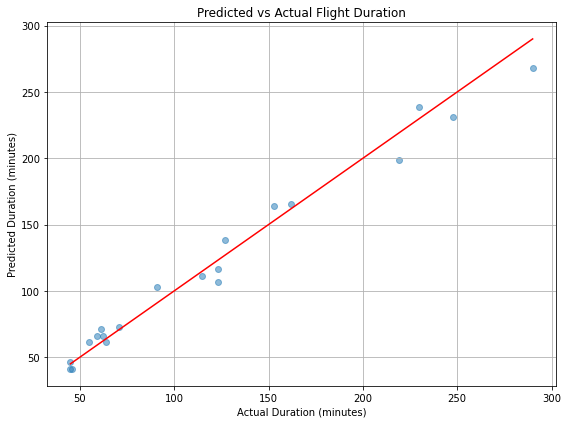

In [7]:
if 'actual_duration' in new_df.columns:
    plt.figure(figsize=(8, 6))
    plt.scatter(new_df['actual_duration'], new_df['predicted_duration'], alpha=0.5)
    plt.xlabel("Actual Duration (minutes)")
    plt.ylabel("Predicted Duration (minutes)")
    plt.title("Predicted vs Actual Flight Duration")
    plt.plot(
        [new_df['actual_duration'].min(), new_df['actual_duration'].max()], 
        [new_df['actual_duration'].min(), new_df['actual_duration'].max()], 
        color='red'
    )
    plt.grid(True)
    plt.tight_layout()
    plt.show()

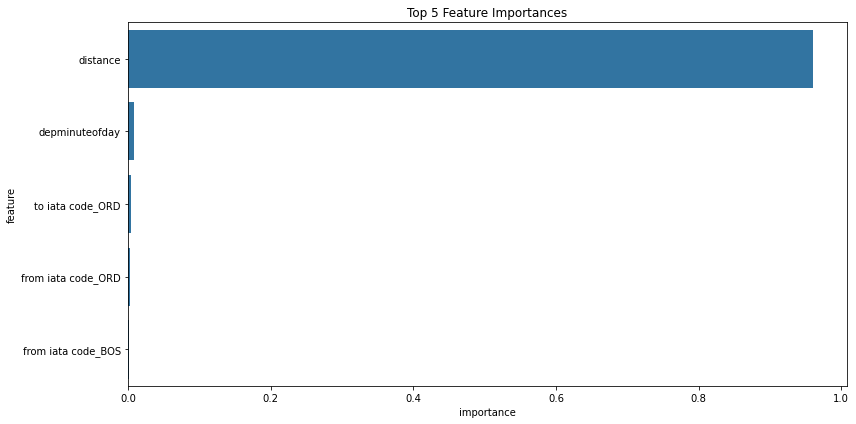

In [8]:
# Feature importance plot
importances = model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(5))
plt.title("Top 5 Feature Importances")
plt.tight_layout()
plt.show()

In [9]:
importances = model.feature_importances_
feature_names = X.columns
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df.sort_values(by='Importance', ascending=False).head(5)

,Feature,Importance
0,distance,0.960215
1,depminuteofday,0.008542
233,to iata code_ORD,0.004258
98,from iata code_ORD,0.002283
17,from iata code_BOS,0.001043
